In [1]:
from Assignment_Queries.pandas_lib.std_imports import *
from Assignment_Queries.pandas_lib.func_lib import *
from Server_Cleaning.modules.Assignment_datasets import *
path = '../'

# Introduction
In this document, we want to perform analyses that provide information about **football clubs**. 
We will pay particular attention to the average goals scored/conceded.
Furthermore, we will focus on one club (of our choice) and analyse it.

In [2]:
# Getting and cleaning the DataFrames
clubs = clear_clubs(get_clubs(path))
club_games = clear_club_games(get_club_games(path))
games = clear_games(get_games(path))
game_events = clear_game_events(get_game_events(path))

# Formations:
We can start seeing some numbers about the most used formation and the way they bring to victories or losses.

In [3]:
top_formations = games.value_counts('home_club_formation').sort_values(ascending=False).head(10)
# Finding games data about this formations
top_10_f_games = (games[games['home_club_formation']
    .isin(top_formations.index)][['home_club_id', 'aggregate', 'home_club_formation']])
top_10_f_games['aggregate'] = (top_10_f_games['aggregate'].apply(lambda x: check_home_win(x)))
# Dividing df by aggregate results
win_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'win'].value_counts('home_club_formation')).rename(columns={'count': 'won'})
loss_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'loss'].value_counts('home_club_formation')).rename(columns={'count': 'loss'})
draw_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'draw'].value_counts('home_club_formation')).rename(columns={'count': 'draw'})
# Joining and plotting
df = win_df.join(draw_df).join(loss_df)

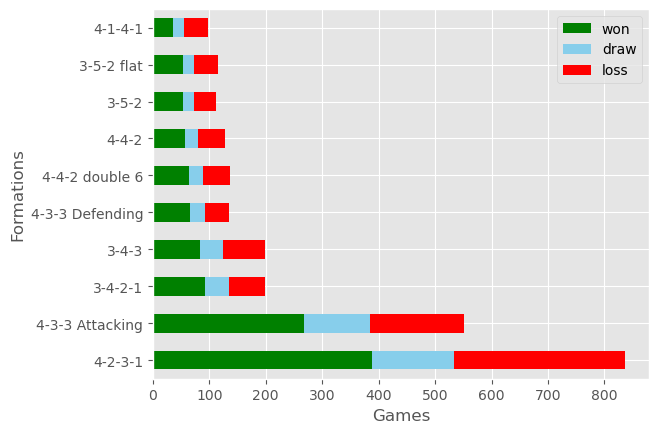

In [4]:
df.plot(kind='barh', stacked=True, color=['green', 'skyblue', 'red'])
plt.xlabel('Games')
plt.ylabel('Formations')
plt.show()

# What do we see?
We can see that the ratio between victories, losses and draw remains almost ever the same throughout all our dataset.
<br>
# And now?
We would like to see **how different formations behave** when deployed against each other.

In [5]:
# We create a DataFrame to inspect data about formation combinations 
format_compare_df = (games.groupby(['home_club_formation', 'away_club_formation'], as_index=False).agg(
    home_avg_goals=pd.NamedAgg(column='home_club_goals', aggfunc='mean'),
    away_avg_goals=pd.NamedAgg(column='away_club_goals', aggfunc='mean'))
                     .rename(columns={'home_club_formation': 'home_formation', 'away_club_formation': 'away_formation'}))
# Adding 'count' column
format_compare_df = format_compare_df.join(games.value_counts(['home_club_formation', 'away_club_formation']), on=['home_formation', 'away_formation'])
# We set the mean of the count as minimum threshold for the data to analyze
format_compare_df = format_compare_df[format_compare_df['count'] > np.mean(format_compare_df['count'])]
format_compare_df['diff']  = format_compare_df['home_avg_goals'] - format_compare_df['away_avg_goals']
# Creating a pivot to display a heatmap 
heatmap_data = format_compare_df[['home_formation', 'away_formation', 'diff']].pivot(index='home_formation', columns='away_formation', values='diff')

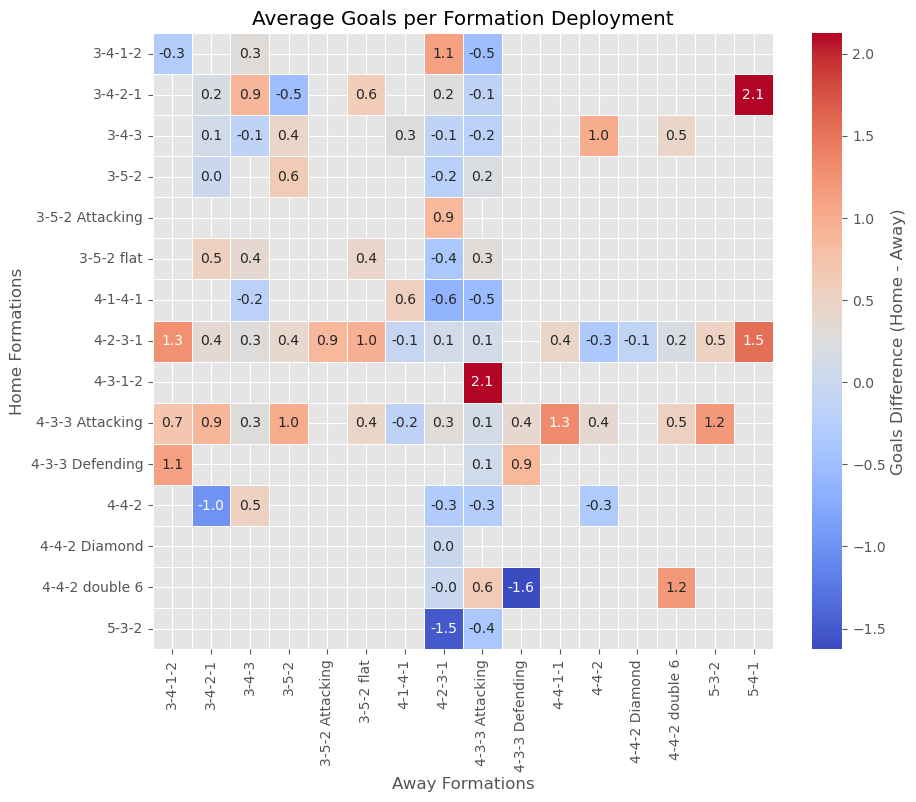

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Goals Difference (Home - Away)'}, fmt='.1f')
plt.title('Average Goals per Formation Deployment')
plt.xlabel('Away Formations')
plt.ylabel('Home Formations')
plt.show()

# Observations:
1. We can see that combinations as **"4-2-3-1"** vs **"4-4-2 double 6"** converge to _0_ _(here 0.17)_ after just 35 matches played.
2. On the other hand, formation **"5-4-1"** tends to be more effective against formations **"4-2-3-1"** and **"3-4-2-1"**, as we can see from the graph which shows us an average of 1.5 and 2 more goals respectively. _(In this case we must point out that there is not much data to work with)_
3. Finally, we focus on data about the formation **"5-3-2"**, where we can see (as follows) that is way better to use it when playing away

In [7]:
# Following line will select only formation tuples containing '5-3-2'
formation_example = heatmap_data[~heatmap_data['5-3-2'].isnull() 
                     | (heatmap_data.index == '5-3-2')][['4-2-3-1', '4-3-3 Attacking', '5-3-2']]
formation_example.loc[formation_example.index != '5-3-2', formation_example.columns != '5-3-2'] = np.nan

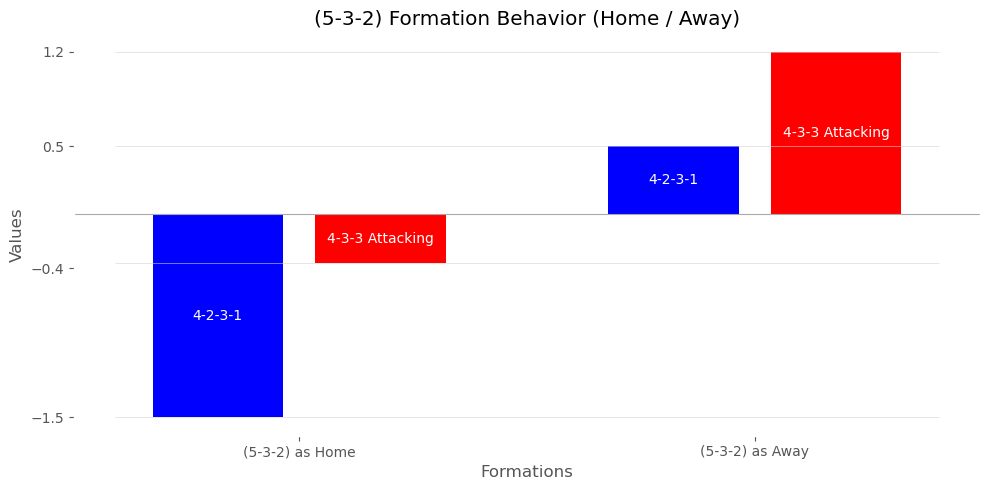

In [8]:
# Create a single multi-bar plot
fig, ax = plt.subplots(figsize=(10, 5))
# Set axis labels
ax.set_xlabel('Formations')
ax.set_ylabel('Values')
# Set x-axis labels (centered between 2 bars)
ax.set_xticks([0.45, 1.85])
ax.set_xticklabels(['(5-3-2) as Home', '(5-3-2) as Away'])
# Highlighting x-axis
ax.axhline(0, color='darkgrey', linewidth=0.8)

bar_w = 0.4
away_translation_pos = 1.6

home_formations = formation_example.loc['5-3-2'].dropna()
away_formations = formation_example['5-3-2'].dropna()
# 5-3-2 Home Formations
ax.bar(0.2, height=home_formations.iloc[0], width=bar_w, color='blue')
ax.text(s=home_formations.index[0], ha='center', va='center', color='white',
        x=0.2, y=home_formations.iloc[0] / 2)
ax.bar(0.2 + bar_w + 0.1, height=home_formations.iloc[1], width=bar_w, color='red')
ax.text(s=home_formations.index[1], ha='center', va='center', color='white',
        x=0.2 + bar_w + 0.1, y=home_formations.iloc[1] / 2)
# 5-3-2 Away Formations
ax.bar(away_translation_pos, height=away_formations.iloc[0], width=bar_w, color='blue')
ax.text(s=away_formations.index[0], ha='center', va='center', color='white',
        x=away_translation_pos, y=away_formations.iloc[0] / 2)
ax.bar(away_translation_pos + bar_w + 0.1, height=away_formations.iloc[1], width=bar_w, color='red', 
       label=away_formations.index[1])
ax.text(s=away_formations.index[1], ha='center', va='center', color='white',
        x=away_translation_pos + bar_w + 0.1, y=away_formations.iloc[1] / 2)

# Customizing the plot
ax.set_title('(5-3-2) Formation Behavior (Home / Away)')
ax.set_facecolor('white')
ax.set_yticks(ticks=np.append(home_formations.values, away_formations.values).round(decimals=1))
ax.hlines(y=np.append(home_formations.values, away_formations.values), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
          linestyle='-', colors='lightgrey', linewidths=(0.4,))

# Show the plot
plt.tight_layout()
plt.show()

# Country Visualization
- We are going to plot a visualization of how much the players are valuated in each country, summing their valuation after we grouped 

In [9]:
pl_val = clear_player_valuations(get_player_valuations(path), get_competitions(path))
pl_val = pl_val.groupby('country_name', as_index=False).agg(sum=pd.NamedAgg('market_value_eur', 'sum'))

# Scotland and England must be merged into United Kingdom
pl_val.at[2, 'country_name'] = 'United Kingdom'
pl_val.at[2, 'sum'] = pl_val.at[2, 'sum'] + pl_val.at[10, 'sum']
pl_val = pl_val.drop(index=10)

# Merging the data of the .topojson with our dataset
europe_gdf = gpd.read_file(path + 'Assignment_Queries/country_topography/europe.topojson')
geo_data = europe_gdf.merge(pl_val, left_on='NAME', right_on='country_name', how='left')
geo_data['sum'] = geo_data['sum'].fillna(0).astype('int64')

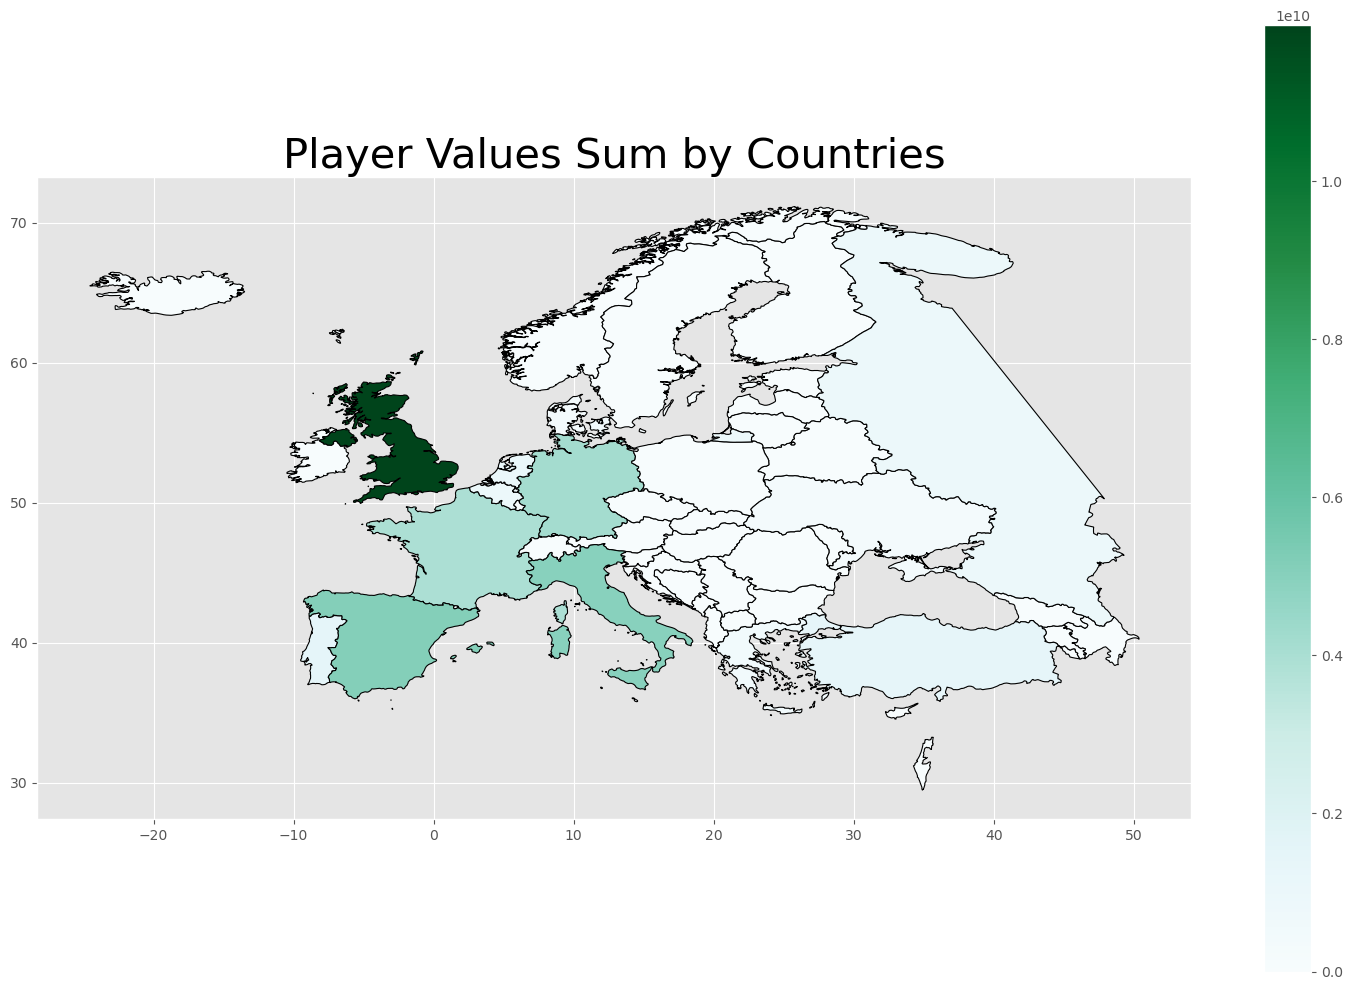

In [10]:
ax = geo_data.plot(figsize=(15,10), edgecolor='black', cmap='BuGn', linewidth=0.8, column='sum', legend=True)
ax.set_title('Player Values Sum by Countries', fontsize='30')

plt.tight_layout()
plt.show()